## Loading the dataset bBSARD and saving as CSV files

In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

os.makedirs("plots", exist_ok=True)
os.makedirs("data/original_csv", exist_ok=True)
os.makedirs("data/original_json", exist_ok=True)

ds_corpus = load_dataset("clips/bBSARD", "corpus")
ds_test = load_dataset("clips/bBSARD", "test")

corpus_fr = ds_corpus['fr']
test_fr = ds_test['fr']

corpus_nl = ds_corpus['nl']
test_nl = ds_test['nl']

queries_fr = test_fr
queries_nl = test_nl


pd.DataFrame(queries_fr).to_csv("data/original_csv/original_queries_fr.csv", index=False)
pd.DataFrame(queries_nl).to_csv("data/original_csv/original_queries_nl.csv", index=False)


print("Saved original queries (French and Dutch) as CSV.")

/opt/anaconda3/envs/llm_legal_document_retrieval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating nl split: 100%|██████████| 222/222 [00:00<00:00, 41402.20 examples/s]

Saved original queries (French and Dutch) as CSV.


In [3]:
print(ds_test.shape, ds_corpus.shape)
print(ds_test)
print(ds_corpus)

{'fr': (222, 6), 'nl': (222, 6)} {'fr': (22417, 3), 'nl': (22417, 3)}
DatasetDict({
    fr: Dataset({
        features: ['id', 'category', 'subcategory', 'question', 'extra_description', 'article_ids'],
        num_rows: 222
    })
    nl: Dataset({
        features: ['id', 'category', 'subcategory', 'question', 'extra_description', 'article_ids'],
        num_rows: 222
    })
})
DatasetDict({
    fr: Dataset({
        features: ['id', 'reference', 'article'],
        num_rows: 22417
    })
    nl: Dataset({
        features: ['id', 'reference', 'article'],
        num_rows: 22417
    })
})


## DATA ANALYSIS (TEST QUERIES)

In [4]:
query_lengths_fr_word = [len(q['question'].split()) for q in queries_fr]
query_lengths_nl_word = [len(q['question'].split()) for q in queries_nl]


df_queries = pd.DataFrame({
    "French Query Length": query_lengths_fr_word,
    "Dutch Query Length": query_lengths_nl_word
})

print(df_queries.describe())

       French Query Length  Dutch Query Length
count           222.000000          222.000000
mean             15.842342           14.972973
std               6.616681            6.811568
min               5.000000            4.000000
25%              11.000000           10.000000
50%              15.000000           14.000000
75%              19.750000           18.000000
max              41.000000           42.000000


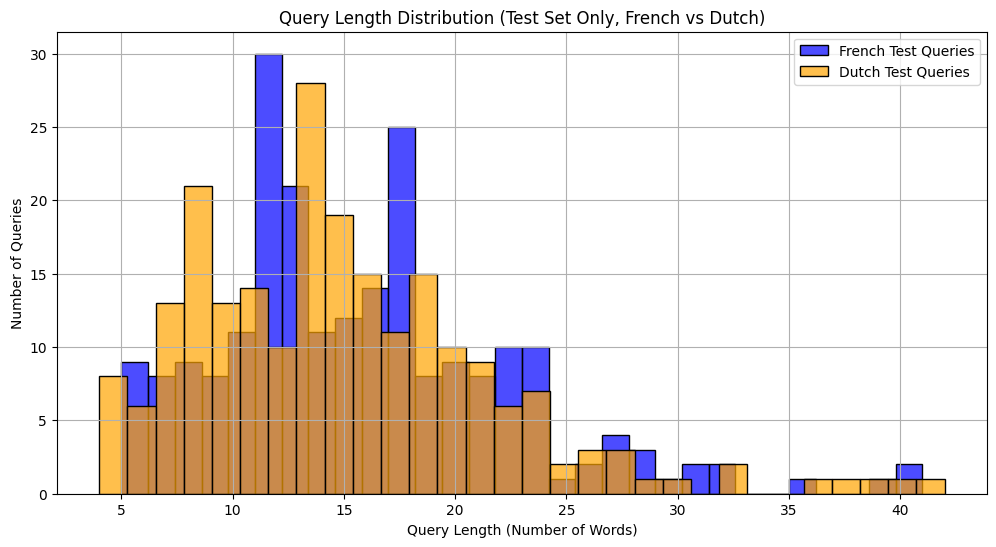

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(query_lengths_fr_word, bins=30, color='blue', label='French Test Queries', alpha=0.7)
sns.histplot(query_lengths_nl_word, bins=30, color='orange', label='Dutch Test Queries', alpha=0.7)

plt.xlabel("Query Length (Number of Words)")
plt.ylabel("Number of Queries")
plt.title("Query Length Distribution (Test Set Only, French vs Dutch)")
plt.legend()
plt.grid(True)
plt.savefig("plots/query_length_histogram_word.png")
plt.show()

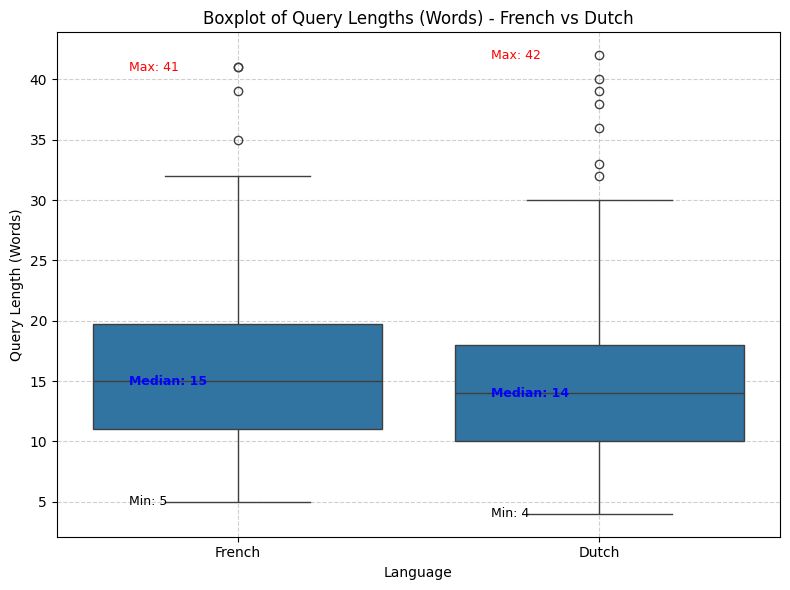

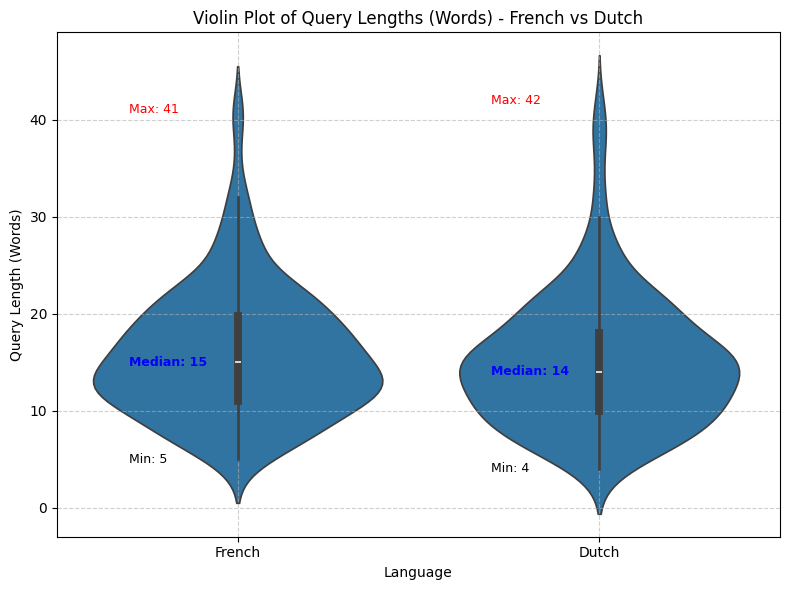

In [6]:
df_word_queries = pd.DataFrame({
    "Length": query_lengths_fr_word + query_lengths_nl_word,
    "Language": ["French"] * len(query_lengths_fr_word) + ["Dutch"] * len(query_lengths_nl_word)
})

stats = df_word_queries.groupby("Language")["Length"].agg(["min", "median", "max"])

plt.figure(figsize=(8, 6))
sns.boxplot(x="Language", y="Length", data=df_word_queries)
plt.title("Boxplot of Query Lengths (Words) - French vs Dutch")
plt.ylabel("Query Length (Words)")
plt.grid(True, linestyle='--', alpha=0.6)

for i, language in enumerate(["French", "Dutch"]):
    plt.text(i - 0.3, stats.loc[language, "min"], f"Min: {int(stats.loc[language, 'min'])}", color="black", va='center', fontsize=9)
    plt.text(i - 0.3, stats.loc[language, "median"], f"Median: {int(stats.loc[language, 'median'])}", color="blue", va='center', fontsize=9, fontweight='bold')
    plt.text(i - 0.3, stats.loc[language, "max"], f"Max: {int(stats.loc[language, 'max'])}", color="red", va='center', fontsize=9)

plt.tight_layout()
plt.savefig("plots/query_length_boxplot_word_with_stats.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(x="Language", y="Length", data=df_word_queries)
plt.title("Violin Plot of Query Lengths (Words) - French vs Dutch")
plt.ylabel("Query Length (Words)")
plt.grid(True, linestyle='--', alpha=0.6)

for i, language in enumerate(["French", "Dutch"]):
    plt.text(i - 0.3, stats.loc[language, "min"], f"Min: {int(stats.loc[language, 'min'])}", color="black", va='center', fontsize=9)
    plt.text(i - 0.3, stats.loc[language, "median"], f"Median: {int(stats.loc[language, 'median'])}", color="blue", va='center', fontsize=9, fontweight='bold')
    plt.text(i - 0.3, stats.loc[language, "max"], f"Max: {int(stats.loc[language, 'max'])}", color="red", va='center', fontsize=9)

plt.tight_layout()
plt.savefig("plots/query_length_violin_word_with_stats.png")
plt.show()

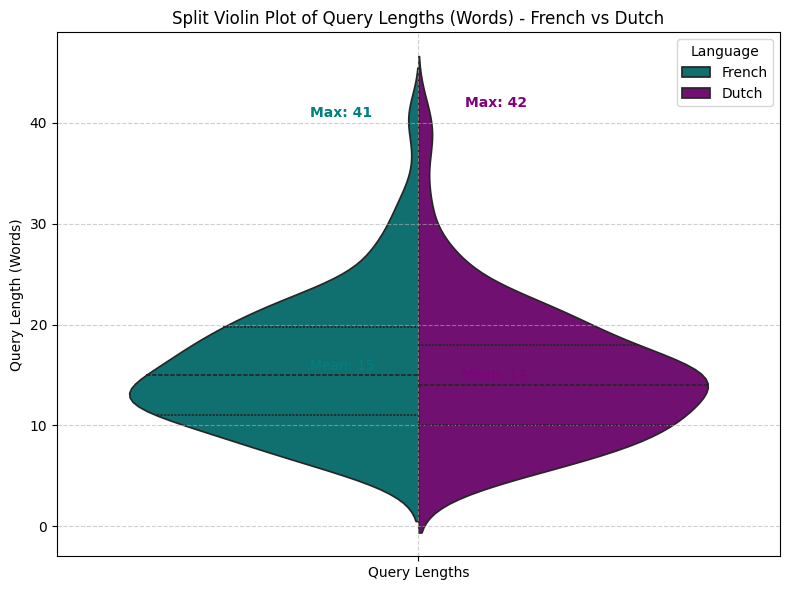

In [7]:

df_word_queries = pd.DataFrame({
    "Length": query_lengths_fr_word + query_lengths_nl_word,
    "Language": ["French"] * len(query_lengths_fr_word) + ["Dutch"] * len(query_lengths_nl_word)
})

mean_fr = sum(query_lengths_fr_word) / len(query_lengths_fr_word)
mean_nl = sum(query_lengths_nl_word) / len(query_lengths_nl_word)

max_fr = max(query_lengths_fr_word)
max_nl = max(query_lengths_nl_word)


plt.figure(figsize=(8, 6))

sns.violinplot(
    x=["Query Lengths"] * len(df_word_queries),
    y="Length",
    hue="Language",
    data=df_word_queries,
    split=True,
    inner="quartile",
    palette={"French": "teal", "Dutch": "purple"}
)

plt.text(-0.15, mean_fr, f"Mean: {int(mean_fr)}", color="teal", va='center', ha='left', fontsize=10)
plt.text(-0.15, max_fr, f"Max: {max_fr}", color="teal", va='center', ha='left', fontsize=10, fontweight='bold')

plt.text(0.15, mean_nl, f"Mean: {int(mean_nl)}", color="purple", va='center', ha='right', fontsize=10)
plt.text(0.15, max_nl, f"Max: {max_nl}", color="purple", va='center', ha='right', fontsize=10, fontweight='bold')

plt.title("Split Violin Plot of Query Lengths (Words) - French vs Dutch")
plt.ylabel("Query Length (Words)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("plots/query_length_split_violin_word_stats_improved.png")
plt.show()

## DATA ANALYSIS (Number of relevant articles) 

In [8]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ds_test = load_dataset("clips/bBSARD", "test")
test_fr = ds_test['fr']
test_nl = ds_test['nl']

relevant_counts_fr = [len([id_.strip() for id_ in query['article_ids'].split(",")]) for query in test_fr]
relevant_counts_nl = [len([id_.strip() for id_ in query['article_ids'].split(",")]) for query in test_nl]

df_stats_queries = pd.DataFrame({
    "French Relevant Articles Count": relevant_counts_fr,
    "Dutch Relevant Articles Count": relevant_counts_nl
})

print(df_stats_queries.describe())

       French Relevant Articles Count  Dutch Relevant Articles Count
count                      222.000000                     222.000000
mean                         4.774775                       4.774775
std                          9.221934                       9.221934
min                          1.000000                       1.000000
25%                          1.000000                       1.000000
50%                          2.000000                       2.000000
75%                          4.000000                       4.000000
max                         57.000000                      57.000000


In [11]:
print("French max:", max(relevant_counts_fr))
print("Dutch max:", max(relevant_counts_nl))
print("df max:", df['Count'].max())
print(df['Count'].describe())

French max: 57
Dutch max: 57
df max: 57
count    444.000000
mean       4.774775
std        9.211520
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       57.000000
Name: Count, dtype: float64


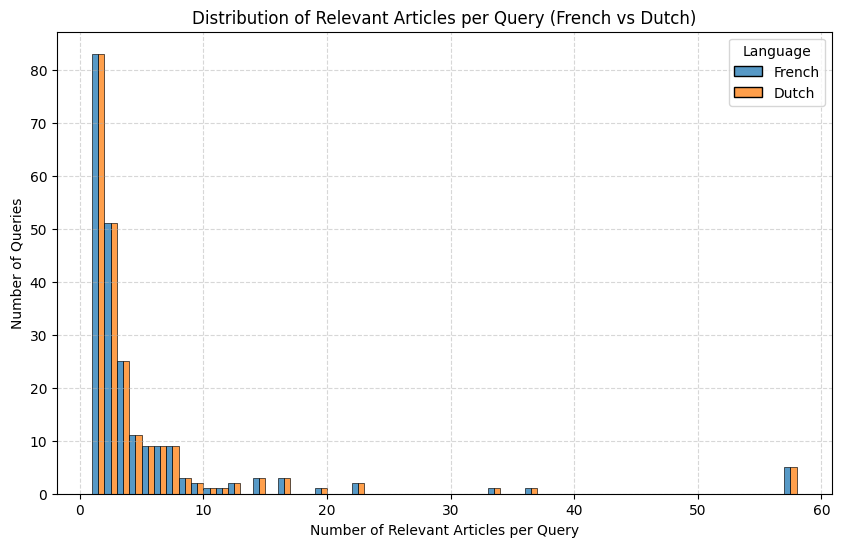

<Figure size 640x480 with 0 Axes>

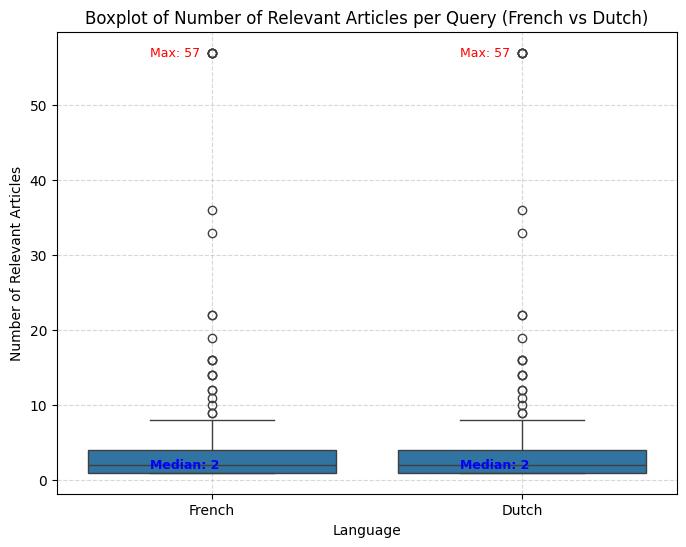

<Figure size 640x480 with 0 Axes>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("plots", exist_ok=True)

df = pd.DataFrame({
    "Count": relevant_counts_fr + relevant_counts_nl,
    "Language": ["French"] * len(relevant_counts_fr) + ["Dutch"] * len(relevant_counts_nl)
})

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Count", hue="Language", multiple="dodge", bins=range(1, df["Count"].max() + 2), edgecolor="black")
plt.title("Distribution of Relevant Articles per Query (French vs Dutch)")
plt.xlabel("Number of Relevant Articles per Query")
plt.ylabel("Number of Queries")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
plt.savefig("plots/num_rel_articles_histogram.png")

plt.figure(figsize=(8, 6))
sns.boxplot(x="Language", y="Count", data=df)

plt.title("Boxplot of Number of Relevant Articles per Query (French vs Dutch)")
plt.ylabel("Number of Relevant Articles")
plt.grid(True, linestyle="--", alpha=0.5)

stats = df.groupby("Language")["Count"].agg(["min", "median", "max"])

for i, language in enumerate(["French", "Dutch"]):
    plt.text(i - 0.2, stats.loc[language, "median"], f"Median: {int(stats.loc[language, 'median'])}", color="blue", va='center', fontsize=9, fontweight='bold')
    plt.text(i - 0.2, stats.loc[language, "max"], f"Max: {int(stats.loc[language, 'max'])}", color="red", va='center', fontsize=9)

plt.show()
plt.savefig("plots/num_rel_articles_boxplot.png")

In [14]:
import json
import os

# Set threshold
threshold = 10

# Find query IDs with more than threshold relevant articles (French)
queries_with_many_fr = [query['id'] for query in test_fr if len([id_ for id_ in query['article_ids'].split(",")]) > threshold]

# Find query IDs with more than threshold relevant articles (Dutch)
queries_with_many_nl = [query['id'] for query in test_nl if len([id_ for id_ in query['article_ids'].split(",")]) > threshold]


df_queries_to_remove = pd.DataFrame({
    "fr": queries_with_many_fr,
    "nl": queries_with_many_nl
})


queries_to_remove = {
    "fr": queries_with_many_fr,
    "nl": queries_with_many_nl
}

with open("queries_with_many_relevant_articles.json", "w", encoding="utf-8") as f:
    json.dump(queries_to_remove, f, ensure_ascii=False, indent=2)

print(f'Saved queries with more than {threshold} relevant articles.')
print("French queries to remove:", len(queries_with_many_fr))
print("Dutch queries to remove:", len(queries_with_many_nl))

print(list(df_queries_to_remove['nl']))
print(list(df_queries_to_remove['fr']))
print(list(df_queries_to_remove['nl']==df_queries_to_remove['fr']))


Saved queries with more than 10 relevant articles.
French queries to remove: 19
Dutch queries to remove: 19
[499, 535, 554, 718, 607, 556, 684, 59, 686, 617, 691, 701, 810, 969, 245, 37, 581, 1025, 616]
[499, 535, 554, 718, 607, 556, 684, 59, 686, 617, 691, 701, 810, 969, 245, 37, 581, 1025, 616]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [17]:
print(df_queries_to_remove)

      fr    nl
0    499   499
1    535   535
2    554   554
3    718   718
4    607   607
5    556   556
6    684   684
7     59    59
8    686   686
9    617   617
10   691   691
11   701   701
12   810   810
13   969   969
14   245   245
15    37    37
16   581   581
17  1025  1025
18   616   616


## Inspecting the Corpus (the articles)

In [18]:
article_lengths_fr = [len(doc['article'].split()) for doc in corpus_fr]
article_lengths_nl = [len(doc['article'].split()) for doc in corpus_nl]

df_stats = pd.DataFrame({
    "French Article Length": article_lengths_fr,
    "Dutch Article Length": article_lengths_nl
})

print(df_stats.describe())

       French Article Length  Dutch Article Length
count           22417.000000          22417.000000
mean              143.209662            142.493955
std               198.275414            192.898446
min                 2.000000              2.000000
25%                42.000000             43.000000
50%                81.000000             81.000000
75%               166.000000            166.000000
max              5969.000000           5236.000000


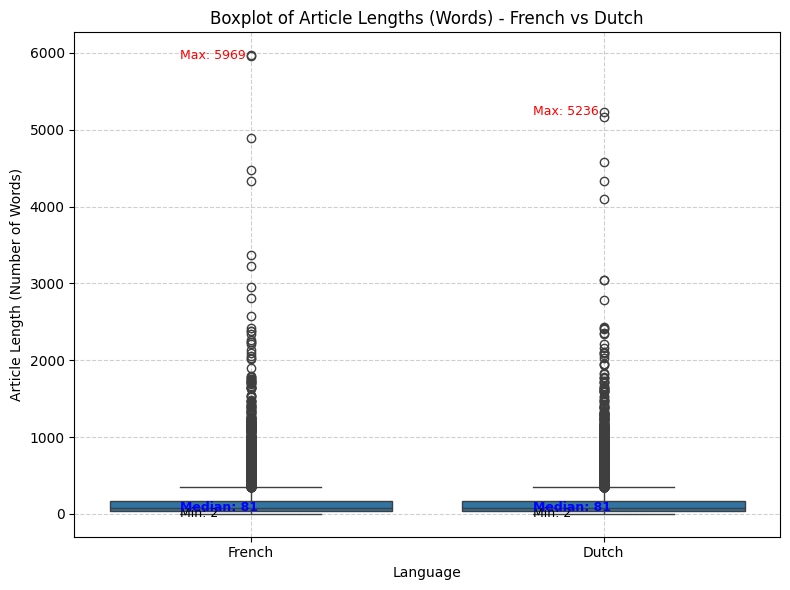

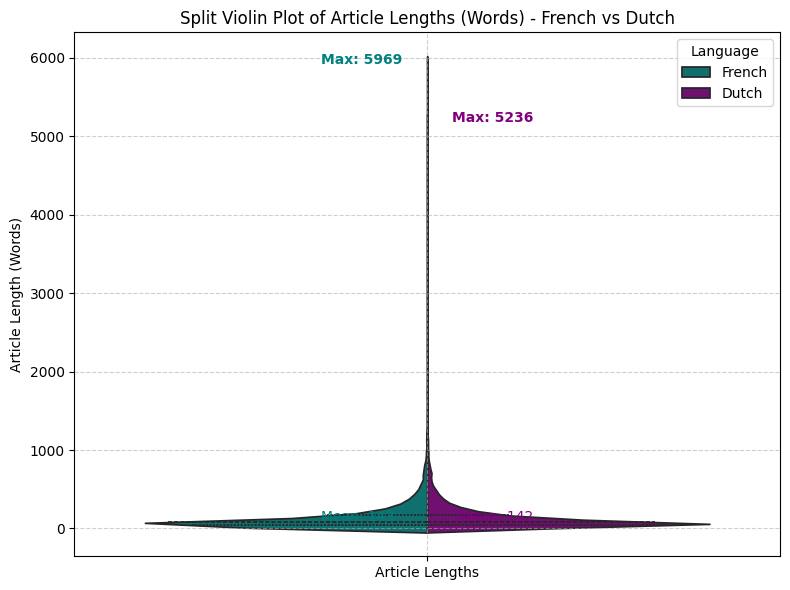

In [19]:
df_corpus = pd.DataFrame({
    "Length": article_lengths_fr + article_lengths_nl,
    "Language": ["French"] * len(article_lengths_fr) + ["Dutch"] * len(article_lengths_nl)
})

stats = df_corpus.groupby("Language")["Length"].agg(["min", "median", "max", "mean"])

plt.figure(figsize=(8, 6))
sns.boxplot(x="Language", y="Length", data=df_corpus)
plt.title("Boxplot of Article Lengths (Words) - French vs Dutch")
plt.ylabel("Article Length (Number of Words)")
plt.grid(True, linestyle='--', alpha=0.6)

for i, language in enumerate(["French", "Dutch"]):
    plt.text(i - 0.2, stats.loc[language, "min"], f"Min: {int(stats.loc[language, 'min'])}", color="black", va='center', fontsize=9)
    plt.text(i - 0.2, stats.loc[language, "median"], f"Median: {int(stats.loc[language, 'median'])}", color="blue", va='center', fontsize=9, fontweight='bold')
    plt.text(i - 0.2, stats.loc[language, "max"], f"Max: {int(stats.loc[language, 'max'])}", color="red", va='center', fontsize=9)

plt.tight_layout()
plt.savefig("plots/article_length_boxplot_word_with_stats.png")
plt.show()


plt.figure(figsize=(8, 6))

sns.violinplot(
    x=["Article Lengths"] * len(df_corpus),
    y="Length",
    hue="Language",
    data=df_corpus,
    split=True,
    inner="quartile",
    palette={"French": "teal", "Dutch": "purple"}
)

plt.text(-0.15, stats.loc["French", "mean"], f"Mean: {int(stats.loc['French', 'mean'])}", color="teal", va='center', ha='left', fontsize=10)
plt.text(-0.15, stats.loc["French", "max"], f"Max: {int(stats.loc['French', 'max'])}", color="teal", va='center', ha='left', fontsize=10, fontweight='bold')

plt.text(0.15, stats.loc["Dutch", "mean"], f"Mean: {int(stats.loc['Dutch', 'mean'])}", color="purple", va='center', ha='right', fontsize=10)
plt.text(0.15, stats.loc["Dutch", "max"], f"Max: {int(stats.loc['Dutch', 'max'])}", color="purple", va='center', ha='right', fontsize=10, fontweight='bold')

plt.title("Split Violin Plot of Article Lengths (Words) - French vs Dutch")
plt.ylabel("Article Length (Words)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("plots/article_length_split_violin_word_with_stats.png")
plt.show()

In [20]:
# Count French articles > 5000 words
long_fr = sum(length > 5000 for length in article_lengths_fr)

# Count Dutch articles > 5000 words
long_nl = sum(length > 5000 for length in article_lengths_nl)

print(f"French articles > 5000 words: {long_fr}")
print(f"Dutch articles > 5000 words: {long_nl}")

French articles > 5000 words: 2
Dutch articles > 5000 words: 2


## Long Articles ##

In [43]:
from datasets import load_dataset
import json

ds_corpus = load_dataset("clips/bBSARD", "corpus")

corpus_fr = ds_corpus['fr']
corpus_nl = ds_corpus['nl']

threshold = 5000

long_articles_fr = [(doc['id'], len(doc['article'])) for doc in corpus_fr if len(doc['article'].split()) > threshold]
num_long_fr = len(long_articles_fr)

long_articles_nl = [(doc['id'], len(doc['article'])) for doc in corpus_nl if len(doc['article'].split()) > threshold]
num_long_nl = len(long_articles_nl)

long_ids_fr = [id for id, length in long_articles_fr]
long_ids_nl = [id for id, length in long_articles_nl]
long_article_ids = list(set(long_ids_fr + long_ids_nl))

with open("long_article_ids.json", "w", encoding="utf-8") as f:
    json.dump(long_article_ids, f, ensure_ascii=False, indent=2)

print(f'Number of long articles in French corpus: {num_long_fr}')
print(f'Number of long articles in Dutch corpus: {num_long_nl}')

Number of long articles in French corpus: 2
Number of long articles in Dutch corpus: 2


In [44]:
print(f'Tuple of ling article id and their lengths in French corpus: {long_articles_fr}')
print(f'Tuple of ling article id and their lengths in Dutch corpus: {long_articles_nl}')
print(f'Long article ids overall: {long_article_ids}')

Tuple of ling article id and their lengths in French corpus: [(13720, 37301), (22198, 39740)]
Tuple of ling article id and their lengths in Dutch corpus: [(13720, 37834), (22198, 36408)]
Long article ids overall: [13720, 22198]
